In [1]:
"""
Fitting some crosses
====================

In this example, we will fit a cross onto the same cross, but rotated. We will
take advantage of this knowledge and use a rotation deformation module. We will
also add some noise on the initial center guess to show how to fit the geometrical
descriptors.

"""

###############################################################################
# We first need to import
#

import sys
sys.path.append("../")

import math

import torch
import matplotlib.pyplot as plt
import scipy.ndimage

import implicitmodules.torch as dm

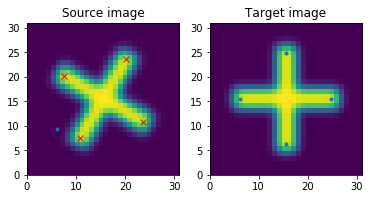

In [2]:
###############################################################################
# We load the data and plot them.
#
path_data = '../data/images/'
source_image = dm.Utilities.load_greyscale_image(path_data + "cross_+_30.png", origin='lower')
target_image = dm.Utilities.load_greyscale_image(path_data + "cross_+.png", origin='lower')

# Smoothing
sig_smooth = 1.
source_image = torch.tensor(scipy.ndimage.gaussian_filter(source_image, sig_smooth))
target_image = torch.tensor(scipy.ndimage.gaussian_filter(target_image, sig_smooth))


extent_length = 31.
extent = dm.Utilities.AABB(0., extent_length, 0., extent_length)

dots = torch.tensor([[0., 0.5],
                     [0.5, 0.],
                     [0., -0.5],
                     [-0.5, 0.]])

source_dots = 0.6*extent_length*dm.Utilities.linear_transform(dots, dm.Utilities.rot2d(math.pi/3)) + extent_length*torch.tensor([0.5, 0.5])

target_dots = 0.6*extent_length*dm.Utilities.linear_transform(dots, dm.Utilities.rot2d(math.pi/1)) + extent_length*torch.tensor([0.5, 0.5])

center = extent_length*torch.tensor([[0.2, 0.3]])
#center = extent_length*torch.tensor([[0.5, 0.5]])

plt.subplot(1, 2, 1)
plt.title("Source image")
plt.imshow(source_image, origin='lower', extent=extent.totuple())
plt.plot(source_dots.numpy()[:, 0], source_dots.numpy()[:, 1], 'xr')
plt.plot(center.numpy()[:, 0], center.numpy()[:, 1], '.')

plt.subplot(1, 2, 2)
plt.title("Target image")
plt.imshow(target_image, origin='lower', extent=extent.totuple())
plt.plot(target_dots.numpy()[:, 0], target_dots.numpy()[:, 1], '.')

plt.show()

In [3]:
center

tensor([[6.2000, 9.3000]])

In [10]:
###############################################################################
# We know that the target cross is the result of some rotation at its origin,
# so we use a local rotation deformation module, with an imprecise center
# position to simulate data aquisition noise.
#
# Since we will optimize the rotation center, we flag it as requiring gradient
# computations using `requires_grad_()`.
#

rotation = dm.DeformationModules.LocalRotation(2, extent_length*0.8, gd=center)


###############################################################################
# We create the model. We set `True` for `fit_gd` so that it also optimize the
# rotation center.
#

source_deformable = dm.Models.DeformableImage(source_image, output='bitmap',
                                              extent='match')
target_deformable = dm.Models.DeformableImage(target_image, output='bitmap',
                                              extent='match')

source_dots_deformable = dm.Models.DeformablePoints(source_dots)
target_dots_deformable = dm.Models.DeformablePoints(target_dots)

attachment = dm.Attachment.L2NormAttachment(transform=None)
new = True
model = dm.Models.RegistrationModel([source_deformable, source_dots_deformable], [rotation], [attachment, dm.Attachment.EuclideanPointwiseDistanceAttachment(0.01)], fit_gd=[True], lam=10., new=new)

In [8]:
###############################################################################
# We fit the model.
#

shoot_solver = 'rk4'
shoot_it = 10
max_it = 1

costs = {}
fitter = dm.Models.Fitter(model, optimizer='torch_lbfgs')

fitter.fit([target_deformable, target_dots_deformable], max_it, costs=costs, options={'shoot_solver': shoot_solver, 'shoot_it': shoot_it, 'line_search_fn': 'strong_wolfe'})

Starting optimization with method torch LBFGS
Initial cost={'deformation': 0.0, 'attach': 1053.38525390625}
Evaluated model with costs=1053.38525390625
Evaluated model with costs=1031.7791309989989
Evaluated model with costs=1023.5236449763179
Evaluated model with costs=900.280864238739
Evaluated model with costs=1140.6239471435547
Evaluated model with costs=740.5756454467773
Evaluated model with costs=1036.039649963379
Evaluated model with costs=736.4945106506348
Evaluated model with costs=736.0931549072266
Evaluated model with costs=734.7616386413574
Evaluated model with costs=728.5755958557129
Evaluated model with costs=566.09375
Evaluated model with costs=563.5534362792969
Evaluated model with costs=1045.0577005147934
Evaluated model with costs=344.0464553833008
Evaluated model with costs=306.87440490722656
Evaluated model with costs=409.3645553588867
Evaluated model with costs=301.7698440551758
Evaluated model with costs=258.8687057495117
Evaluated model with costs=240.09375
Evalu

In [11]:
model.init_manifold.gd[2]

tensor([[6.2000, 9.3000]], requires_grad=True)

In [12]:
###############################################################################
# We fit the model.
#

shoot_solver = 'rk4'
shoot_it = 10
max_it = 1

costs = {}
fitter = dm.Models.Fitter(model, optimizer='torch_lbfgs')

fitter.fit([target_deformable, target_dots_deformable], max_it, costs=costs, options={'shoot_solver': shoot_solver, 'shoot_it': shoot_it, 'line_search_fn': 'strong_wolfe'})

Starting optimization with method torch LBFGS
Initial cost={'deformation': 0.0, 'attach': 1053.38525390625}
Evaluated model with costs=1053.38525390625
Evaluated model with costs=1042.3990040533245
Evaluated model with costs=1037.9486329108477
Evaluated model with costs=853.6403436660767
Evaluated model with costs=831.6954298019409
Evaluated model with costs=830.7099189758301
Evaluated model with costs=818.6651735305786
Evaluated model with costs=816.7070446014404
Evaluated model with costs=816.1062345504761
Evaluated model with costs=816.096001625061
Evaluated model with costs=816.0718574523926
Evaluated model with costs=1940.0270385742188
Evaluated model with costs=785.7296371459961
Evaluated model with costs=1533.4903869628906
Evaluated model with costs=769.8176155090332
Evaluated model with costs=762.2118396759033
Evaluated model with costs=761.5062046051025
Evaluated model with costs=761.5433235168457
Evaluated model with costs=761.5059261322021
Evaluated model with costs=761.5036

In [6]:
cost = model.evaluate([target_deformable, target_dots_deformable], solver = 'rk4', it=10)

In [14]:
model.init_manifold.gd[2].grad

tensor([[-7.3191, -2.3926]])

In [5]:
###############################################################################
# We fit the model.
#

shoot_solver = 'rk4'
shoot_it = 10
max_it = 100

costs = {}
fitter = dm.Models.Fitter(model, optimizer='torch_lbfgs')

fitter.fit([target_deformable, target_dots_deformable], max_it, costs=costs, options={'shoot_solver': shoot_solver, 'shoot_it': shoot_it, 'line_search_fn': 'strong_wolfe'})

Starting optimization with method torch LBFGS
Initial cost={'deformation': 0.0, 'attach': 262755.8125}
Evaluated model with costs=262755.8125
Evaluated model with costs=257668.80671890825
Evaluated model with costs=256249.976210095
Evaluated model with costs=239003.1171963215
Evaluated model with costs=232721.32363128662
Evaluated model with costs=213572.47013568878
Evaluated model with costs=203839.1149711609
Evaluated model with costs=192981.14447784424
Evaluated model with costs=192532.21521377563
Evaluated model with costs=191809.579536438
Evaluated model with costs=231830.88022613525
Evaluated model with costs=157643.95668029785
Evaluated model with costs=147419.99632263184
Evaluated model with costs=140232.90632629395
Evaluated model with costs=99771.04772949219
Evaluated model with costs=86074.0188293457
Evaluated model with costs=80874.92878723145
Evaluated model with costs=76720.84594726562
Evaluated model with costs=194567.7276916504
Evaluated model with costs=66225.738479614

In [ ]:
###############################################################################
# Plot total cost evolution
#

total_costs = [sum(cost) for cost in list(map(list, zip(*costs.values())))]

plt.title("Total cost evolution")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.grid(True)
plt.plot(range(len(total_costs)), total_costs, color='black', lw=0.7)
plt.show()

In [14]:
###############################################################################
# we compute the deformed source and plot it.
#

with torch.autograd.no_grad():
    model.deformables[0].output = 'bitmap'
    deformed = model.compute_deformed(shoot_solver, shoot_it)

    deformed_image = deformed[0][0].view_as(source_image)
    deformed_dots = deformed[1][0]
    

Fitted rotatation center: [[15.530426979064941, 15.4368257522583]]


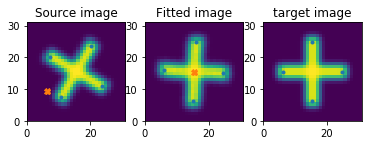

In [15]:
fitted_center = model.init_manifold[2].gd.detach()

print("Fitted rotatation center: {center}".format(center=fitted_center.detach().tolist()))

plt.subplot(1, 3, 1)
plt.title("Source image")
plt.imshow(source_image.numpy(), origin='lower', extent=extent.totuple())
plt.plot(source_dots.numpy()[:, 0], source_dots.numpy()[:, 1], '.')
plt.plot(center.numpy()[0, 0], center.numpy()[0, 1], 'X')

plt.subplot(1, 3, 2)
plt.title("Fitted image")
plt.imshow(deformed_image.numpy(), origin='lower', extent=extent.totuple())
plt.plot(deformed_dots.numpy()[:, 0], deformed_dots.numpy()[:, 1], '.')
plt.plot(fitted_center.numpy()[0, 0], fitted_center.numpy()[0, 1], 'X')

plt.subplot(1, 3, 3)
plt.title("target image")
plt.imshow(target_image.numpy(), origin='lower', extent=extent.totuple())
plt.plot(target_dots.numpy()[:, 0], target_dots.numpy()[:, 1], '.')

plt.show()

In [20]:
with torch.autograd.no_grad():
    model.deformables[0].output = 'bitmap'
    deformed_new = model.compute_deformed_new(shoot_solver, shoot_it)

    deformed_image_new = deformed_new[0][0].view_as(source_image)
    deformed_dots_new = deformed_new[1][0]

Fitted rotatation center: [[6.291045188903809, 9.340530395507812]]


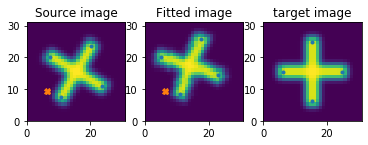

In [21]:
fitted_center = model.init_manifold[2].gd.detach()

print("Fitted rotatation center: {center}".format(center=fitted_center.detach().tolist()))

plt.subplot(1, 3, 1)
plt.title("Source image")
plt.imshow(source_image.numpy(), origin='lower', extent=extent.totuple())
plt.plot(source_dots.numpy()[:, 0], source_dots.numpy()[:, 1], '.')
plt.plot(center.numpy()[0, 0], center.numpy()[0, 1], 'X')

plt.subplot(1, 3, 2)
plt.title("Fitted image")
plt.imshow(deformed_image_new.numpy(), origin='lower', extent=extent.totuple())
plt.plot(deformed_dots_new.numpy()[:, 0], deformed_dots_new.numpy()[:, 1], '.')
plt.plot(fitted_center.numpy()[0, 0], fitted_center.numpy()[0, 1], 'X')

plt.subplot(1, 3, 3)
plt.title("target image")
plt.imshow(target_image.numpy(), origin='lower', extent=extent.totuple())
plt.plot(target_dots.numpy()[:, 0], target_dots.numpy()[:, 1], '.')

plt.show()

NameError: name 'deformed_image' is not defined

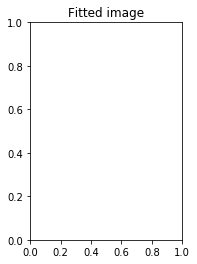

In [13]:
fitted_center = model.init_manifold[2].gd.detach()

plt.subplot(1, 2, 1)
plt.title("Fitted image")
plt.imshow(deformed_image.numpy(), origin='lower', extent=extent.totuple())
plt.plot(deformed_dots.numpy()[:, 0], deformed_dots.numpy()[:, 1], '.')
plt.plot(fitted_center.numpy()[0, 0], fitted_center.numpy()[0, 1], 'X')

plt.subplot(1, 2, 2)
plt.title("old deformation Fitted image")
plt.imshow(deformed_image_new.numpy(), origin='lower', extent=extent.totuple())
plt.plot(deformed_dots.numpy()[:, 0], deformed_dots.numpy()[:, 1], '.')
plt.plot(fitted_center.numpy()[0, 0], fitted_center.numpy()[0, 1], 'X')


In [14]:
fitted_center

tensor([[15.5000, 15.5000]])

In [48]:
model.modules[0].manifold.gd

tensor([[ 0.,  0.],
        [ 1.,  0.],
        [ 2.,  0.],
        ...,
        [29., 31.],
        [30., 31.],
        [31., 31.]])

In [61]:
compound_module = dm.DeformationModules.CompoundModule(model.deformation_modules)

In [62]:
compound_module.manifold.fill_gd([manifold.gd for manifold in model.init_manifold[len(model.deformables):]])
compound_module.manifold.fill_cotan([manifold.cotan for manifold in model.init_manifold[len(model.deformables):]])

for deformable, deformable_manifold in zip(model.deformables, model.init_manifold):
    deformable.silent_module.manifold.fill(deformable_manifold)

In [63]:
# Regroup silent modules of each deformable and build a compound module
silent_modules = [deformable.silent_module for deformable in model.deformables]
compound = dm.DeformationModules.CompoundModule([*silent_modules, *model.modules])

# Forward shooting
dm.HamiltonianDynamic.shoot(dm.HamiltonianDynamic.Hamiltonian(compound), shoot_solver, shoot_it, intermediates=None)



In [66]:
source_defo_reco = source_deformable._to_deformed(model.modules[0].manifold.gd)[0]
sourcedots_defo_reco = source_dots_deformable._to_deformed(model.modules[1].manifold.gd)[0]

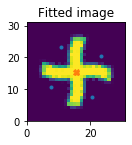

In [70]:
plt.subplot(1, 3, 2)
plt.title("Fitted image")
plt.imshow(source_defo_reco.detach().numpy(), origin='lower', extent=extent.totuple())
plt.plot(sourcedots_defo_reco.detach().numpy()[:, 0], sourcedots_defo_reco.detach().numpy()[:, 1], '.')
plt.plot(fitted_center.numpy()[0, 0], fitted_center.numpy()[0, 1], 'X')


In [59]:
source_defo_reco = source_deformable.compute_deformed(model.modules, shoot_solver, shoot_it)[0]

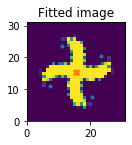

In [60]:
plt.subplot(1, 3, 2)
plt.title("Fitted image")
plt.imshow(source_defo_reco.detach().numpy(), origin='lower', extent=extent.totuple())
plt.plot(deformed_dots.numpy()[:, 0], deformed_dots.numpy()[:, 1], '.')
plt.plot(fitted_center.numpy()[0, 0], fitted_center.numpy()[0, 1], 'X')


In [12]:
gridpts = model.init_manifold.gd[0]

In [13]:
res_grid = [32, 32]

In [14]:
gridmod = dm.DeformationModules.DeformationGrid(source_deformable.extent, res_grid)

In [15]:
gridpts = source_deformable.silent_module.manifold.gd

In [16]:
gridmod.manifold.fill_gd(gridpts)
grid = gridmod.togrid()

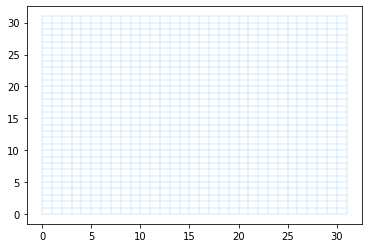

In [17]:
ax = plt.subplot()
dm.Utilities.plot_grid(ax, grid[0], grid[1], color='xkcd:light blue', lw=0.4)

In [18]:
ham = dm.HamiltonianDynamic.Hamiltonian(dm.DeformationModules.CompoundModule(model.modules))
#ham.module.fill_cotan(model.init_manifold.cotan)

In [19]:
intermediates = {}
dm.HamiltonianDynamic.shoot(ham, shoot_solver, shoot_it, intermediates=intermediates)

In [20]:
gridpts_defo = ham.module[0].manifold.gd
gridmod.manifold.fill_gd(gridpts_defo)
grid_defo = gridmod.togrid()

In [21]:
ind0 = []
ind1 = []
ind2 = []
ind3 = []
for p in gridpts:
    dist = torch.argmin(torch.sum( (gridpts_defo - p)**2, dim=1))
    ind0.append(dist)
    #ind1.append(dist[1])
    #ind2.append(dist[2])
    #ind3.append(dist[3])

In [22]:
gridpts_defo_vec = gridpts_defo.unsqueeze(0).transpose(1,2)

In [53]:
normdiff = torch.sum( (gridpts_defo_vec -gridpts.unsqueeze(2))**2, dim=1)
ind0 = torch.argmin( normdiff, dim=1)
_, ind_nearest = torch.topk(normdiff, k=1, dim=1, largest=False)

In [54]:
torch.mean(gridpts[ind_nearest[:,:]], 1).shape

torch.Size([1024, 2])

In [55]:
#gridpts_defo_inv = gridpts[ind0]
gridpts_defo_inv = torch.mean(gridpts[ind_nearest[:,]], 1)
gridmod.manifold.fill_gd(gridpts_defo_inv)
grid_defo_inv = gridmod.togrid()


In [56]:
image_defo_new = dm.Utilities.deformed_intensities(gridpts_defo_inv, source_image, extent)

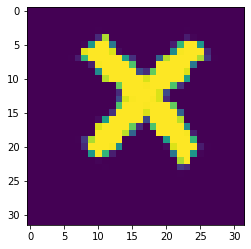

In [57]:
plt.imshow(image_defo_new)

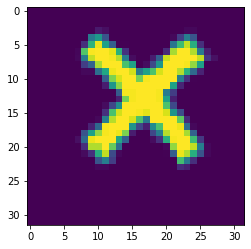

In [52]:
plt.imshow(image_defo_new)

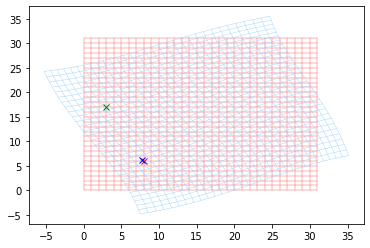

In [90]:
ax = plt.subplot()
ii = 200
dm.Utilities.plot_grid(ax, grid[0], grid[1], color='xkcd:light red', lw=0.4)
dm.Utilities.plot_grid(ax, grid_defo[0], grid_defo[1], color='xkcd:light blue', lw=0.4)
plt.plot(gridpts[ii, 0], gridpts[ii, 1], 'xr')
plt.plot(gridpts_defo[ind0[ii], 0].detach(), gridpts_defo[ind0[ii], 1].detach(), 'xb')
plt.plot(gridpts_defo_inv[ind0[ii], 0].detach(), gridpts_defo_inv[ind0[ii], 1].detach(), 'xg')

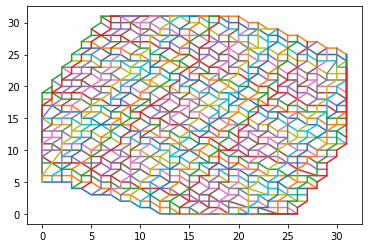

In [91]:
ax = plt.subplot()
#dm.Utilities.plot_grid(ax, grid_defo[0], grid_defo[1], color='xkcd:light blue', lw=0.4)
dm.Utilities.plot_grid(ax, grid_defo_inv[0], grid_defo_inv[1])#, color='xkcd:light blue', lw=0.4)

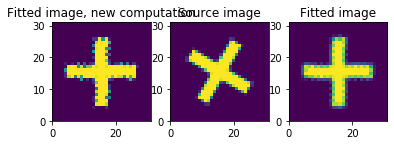

In [46]:

plt.subplot(1, 3, 1)
plt.title("Fitted image, new computation")
plt.imshow(image_defo_new.numpy(), origin='lower', extent=extent.totuple())
plt.subplot(1, 3, 2)
plt.title("Source image")
plt.imshow(source_image.numpy(), origin='lower', extent=extent.totuple())
plt.subplot(1, 3, 3)
plt.title("Fitted image")
plt.imshow(deformed_image.numpy(), origin='lower', extent=extent.totuple())

In [95]:
source_deformable.silent_module.manifold.gd

tensor([[ 7.4914, -4.8169],
        [ 8.5589, -4.5417],
        [ 9.6102, -4.2442],
        ...,
        [22.3977, 34.8499],
        [23.5382, 35.2036],
        [24.6912, 35.5368]], grad_fn=<ViewBackward>)

In [99]:
source_deformable._backward_module().manifold.gd

tensor([[ 0.,  0.],
        [ 1.,  0.],
        [ 2.,  0.],
        ...,
        [29., 31.],
        [30., 31.],
        [31., 31.]])